# Machine Learning to forecast Bitcoin price movements
# Part 4: XGBoost model

In this notebook, we will deploy a high-level XGBoost model to forecast Bitcoin price and predict price movements. More information on the data preprocessing, and labels used can be found in the [`data sourcing and preparation notebook`](./1%20-%20Data%20sourcing%20and%20preparation.ipynb). We will be using as a bechmark our own adaptation of Udacity's [Predicting Boston Housing Prices example](https://github.com/udacity/sagemaker-deployment/blob/master/Tutorials/Boston%20Housing%20-%20XGBoost%20(Deploy)%20-%20High%20Level.ipynb) and the [Hyperparameter tuning example](https://github.com/udacity/sagemaker-deployment/blob/master/Tutorials/Boston%20Housing%20-%20XGBoost%20(Hyperparameter%20Tuning)%20-%20High%20Level.ipynb). The data infeeds and produced outputs, can be found in the `xg-boost/` folder.

We will start by importing necessary libraries and setting up our AWS session and role.

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

session = sagemaker.Session()
role = get_execution_role()

print(session)
print(role)

arn:aws:iam::724888201472:role/service-role/AmazonSageMaker-ExecutionRole-20201115T171901


## Data preprocessing

We will use the previously gotten features from the PCA model to feed in our XGBoost algorithm. Since **Amazon's XGBoost expects the data to be featured in a certain format** and uploaded to an S3 bucket, we will do this in the following lines of code.

In [3]:
pca_list = ['train','test']
store_list = ['train_ny','test_ny', 'test_y', 'train_y']
data = {}

for i in range(len(pca_list)):
    data[pca_list[i]] = pd.read_csv('pca/'+pca_list[i]+'.csv')
    data[pca_list[i]].drop(columns=['Unnamed: 0'], inplace=True)

    
for i in range(len(store_list)):
    data[store_list[i]] = pd.read_csv('data/'+store_list[i]+'.csv')
    data[store_list[i]].drop(columns=['Date'], inplace=True)

for x in data:
    print(data[x].tail())

      component_1  component_2  component_3  component_4  component_5  \
1835    -0.969989     0.277599     1.156140    -0.504672     0.093084   
1836    -1.021743    -0.387731     0.668942    -1.065100     0.019552   
1837    -1.014022    -0.547216     0.744433    -0.930917    -0.007225   
1838    -0.982989    -0.201810     0.978394    -0.659704     0.025067   
1839    -1.002244    -0.653113     0.796150    -0.846429    -0.014283   

      component_6  
1835     0.751546  
1836     0.723636  
1837     0.700540  
1838     0.725947  
1839     0.686890  
     component_1  component_2  component_3  component_4  component_5  \
865    -1.036036    -0.093710     1.092969    -0.883055    -0.580162   
866    -1.036391    -0.093952     1.088533    -0.877775    -0.580377   
867    -1.043998    -0.094252     1.107241    -0.897663    -0.571674   
868    -1.070880    -0.092534     1.132252    -0.923670    -0.555636   
869    -1.057992    -0.091633     1.120212    -0.912363    -0.566596   

     com

In [4]:
data['train_ny']['r_label'].tail()

1835    0.546082
1836    0.503604
1837    0.505318
1838    0.470874
1839    0.516555
Name: r_label, dtype: float64

In [5]:
# This is our local data directory
data_dir = './xg-boost/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

On validation and training datasets, **Amazon expects the first column to be the target variable** and we **should not include index nor headers** in the csv's we will use. Additionally, we will split the test data into validation and testing, to make sure we are able to do hyperparameter tuning afterwards. On the testing data sets, no labels should be included.

In [6]:
# Forecasting/Regression
data['test'].iloc[400:].to_csv(os.path.join(data_dir, 'rtest.csv'), header=False, index=False)
pd.concat([data['test_ny']['r_label'].iloc[:400], data['test'].iloc[:400]], axis=1).to_csv(os.path.join(data_dir, 'rvalidation.csv'), header=False, index=False)
pd.concat([data['train_ny']['r_label'], data['train']], axis=1).to_csv(os.path.join(data_dir, 'rtrain.csv'), header=False, index=False)

# Classification
data['test'].iloc[400:].to_csv(os.path.join(data_dir, 'ctest.csv'), header=False, index=False)
pd.concat([data['test_y']['c_label'].iloc[:400], data['test'].iloc[:400]], axis=1).to_csv(os.path.join(data_dir, 'cvalidation.csv'), header=False, index=False)
pd.concat([data['train_y']['c_label'], data['train']], axis=1).to_csv(os.path.join(data_dir, 'ctrain.csv'), header=False, index=False)

In [7]:
# Uploading to S3
prefix = 'capstone-xgboost'

r_test_location = session.upload_data(os.path.join(data_dir, 'rtest.csv'), key_prefix=prefix)
r_val_location = session.upload_data(os.path.join(data_dir, 'rvalidation.csv'), key_prefix=prefix)
r_train_location = session.upload_data(os.path.join(data_dir, 'rtrain.csv'), key_prefix=prefix)

c_test_location = session.upload_data(os.path.join(data_dir, 'ctest.csv'), key_prefix=prefix)
c_val_location = session.upload_data(os.path.join(data_dir, 'cvalidation.csv'), key_prefix=prefix)
c_train_location = session.upload_data(os.path.join(data_dir, 'ctrain.csv'), key_prefix=prefix)

## Training the XGBoost model - Price Forecasting

We will use the high-level Sagemaker API to do the training job using the XGBoost model, but it is possible to use any other algorithm found in [this list](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html). Since this is a regression problem, we will use `reg:squarederror` as an objective. To **select the initial values of the hyperparameters and perform hyperparameter tuning**, we will use [Amazon's recommended seeds and ranges](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html) for the XGBoost algorithm.

In [8]:
# Construct the image of the training container
container = sagemaker.image_uris.retrieve("xgboost", session.boto_region_name, "1.2-1")

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, 
                                    role,      
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

In [9]:
# Now we set our hyperparameters
xgb.set_hyperparameters(max_depth=5,
                        eta=0.1,
                        gamma=0.1,
                        min_child_weight=6,
                        subsample=0.2,
                        objective='reg:squarederror',
                        early_stopping_rounds=10,
                        num_round=200)

In the following cells, we will perform hyperparameter tuning using `sagemaker tuner` library. As the objective metric, **we will minimize `validation:rmse`** (root mean square error) which is the recommended validation metric for our chosen objective. All ranges stated below, are an intersection of Amazon's recommendation (mentioned above), plus our expert hypothesis taking into account [other recommendations](https://kevinvecmanis.io/machine%20learning/hyperparameter%20tuning/dataviz/python/2019/05/11/XGBoost-Tuning-Visual-Guide.html#introduction). 

In [10]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, 
                                               objective_metric_name = 'validation:rmse', 
                                               objective_type = 'Minimize', 
                                               max_jobs = 20, 
                                               max_parallel_jobs = 3, 
                                               hyperparameter_ranges = {
                                                    'eta'      : ContinuousParameter(0.1, 0.5),
                                                    'alpha': ContinuousParameter(0.1, 750),
                                                    'min_child_weight': IntegerParameter(1, 120),
                                                    'subsample': ContinuousParameter(0.1,0.8),
                                                    'num_round': IntegerParameter(1,4000)
                                               })

In [11]:
# Now we pass in our training and validation input, specifying the type of data.

s3_input_train = sagemaker.TrainingInput(s3_data=r_train_location, content_type='csv')
s3_input_validation = sagemaker.TrainingInput(s3_data=r_val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

........................................................................................................................................................................................................................................................................................................................!


In [12]:
xgb_hyperparameter_tuner.wait()

!


In [13]:
xgb_hyperparameter_tuner.best_training_job()

'sagemaker-xgboost-201231-1150-010-9c871376'

In [14]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())


2020-12-31 12:05:30 Starting - Preparing the instances for training
2020-12-31 12:05:30 Downloading - Downloading input data
2020-12-31 12:05:30 Training - Training image download completed. Training in progress.
2020-12-31 12:05:30 Uploading - Uploading generated training model
2020-12-31 12:05:30 Completed - Training job completed


## Model testing
Here we will do a batch transform job to test our trained model, over the test dataset and see how it performs. For this we first instantiate a transformer and then pass in our feed dataset for the training (and hyperparameter tuning) job.

In [15]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [16]:
xgb_transformer.transform(r_test_location, content_type='text/csv')

................................[2020-12-31:12:22:29:INFO] No GPUs detected (normal if no gpus installed)
[2020-12-31:12:22:29:INFO] No GPUs detected (normal if no gpus installed)
[2020-12-31:12:22:29:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }

  }
}


2020/12/31 12:22:29 [crit] 21#21: *1 conn

In [17]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir
Y_pred = pd.read_csv(os.path.join(data_dir, 'rtest.csv.out'), header=None)

download: s3://sagemaker-eu-central-1-724888201472/sagemaker-xgboost-2020-12-31-12-17-16-745/rtest.csv.out to xg-boost/rtest.csv.out


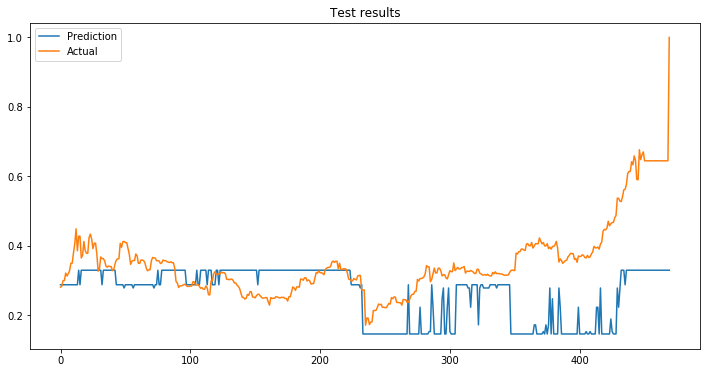

In [18]:
plt.figure(figsize=(12,6))
plt.plot(Y_pred, label='Prediction')
plt.plot(data['test_ny']['r_label'].iloc[400:].values, label='Actual')
plt.title('Test results')
plt.legend()
plt.show()

In [19]:
r_results = pd.concat([Y_pred, data['test_ny'].iloc[400:].reset_index().r_label], axis = 1)
rmse = np.sqrt(np.square(r_results[0] - r_results['r_label']).mean())
print('RSME on test data: '+str(rmse))

RSME on test data: 0.1507606530293286


Unfortunately, **although RSME is at 0.15, results in the test dataset doesn't seem very good if we consider the obtained curve**, and we will discuss probable reasons for this in the discussion section below. We will compare these results with the Neural Network model, and see which one performs better in the end.

# Price movement predictions (classifier)
## Training the model
Now we will perform similar steps as before, but to predict price movements and trading signals (buy, sell, keep out). We also start by instantiating an estimator and a HyperparameterTuner, passing in recommended objective and hyperparameter ranges, so Sagemaker we can pick the best performing job in the end. For this problem, **we will use `multi:softmax` as an objective**, since it is reported to perform well on multi-class classification problems. In our case, this is adequate, as we want to classify 'sell' (0), 'keep out' (1) and 'buy' (2) signals. 

In [37]:
# Construct the image of the training container
container_c = sagemaker.image_uris.retrieve("xgboost", session.boto_region_name, "1.2-1")

# Now that we know which container to use, we can construct the estimator object.
xgb_c = sagemaker.estimator.Estimator(container_c, 
                                    role,      
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

In [38]:
# Now we set our hyperparameters
xgb_c.set_hyperparameters(max_depth=5,
                        eta=0.1,
                        gamma=0.1,
                        min_child_weight=6,
                        subsample=0.2,
                        objective='multi:softmax',
                        early_stopping_rounds=10,
                        num_class=3)

In [39]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner_c = HyperparameterTuner(estimator = xgb_c, 
                                               objective_metric_name = 'validation:accuracy', 
                                               objective_type = 'Maximize', 
                                               max_jobs = 20, 
                                               max_parallel_jobs = 3, 
                                               hyperparameter_ranges = {
                                                    'eta'      : ContinuousParameter(0.1, 0.5),
                                                    'alpha': ContinuousParameter(0.1, 750),
                                                    'min_child_weight': IntegerParameter(1, 100),
                                                    'subsample': ContinuousParameter(0.1,0.8),
                                                    'num_round': IntegerParameter(1,4000)
                                               })

In [40]:
# Now we pass in our training and validation input, specifying the type of data.

s3_input_train_c = sagemaker.TrainingInput(s3_data=c_train_location, content_type='csv')
s3_input_validation_c = sagemaker.TrainingInput(s3_data=c_val_location, content_type='csv')

xgb_hyperparameter_tuner_c.fit({'train': s3_input_train_c, 'validation': s3_input_validation_c})

.........................................................................................................................................................................................................................................................................................................................!


In [41]:
xgb_hyperparameter_tuner_c.wait()

!


In [42]:
xgb_hyperparameter_tuner_c.best_training_job()

'sagemaker-xgboost-201231-1301-001-14ce7ebb'

In [43]:
xgb_attached_c = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner_c.best_training_job())


2020-12-31 13:04:51 Starting - Preparing the instances for training
2020-12-31 13:04:51 Downloading - Downloading input data
2020-12-31 13:04:51 Training - Training image download completed. Training in progress.
2020-12-31 13:04:51 Uploading - Uploading generated training model
2020-12-31 13:04:51 Completed - Training job completed


# Testing the classification model
Similarly, we want to test on the testing dataset an see how the model performs. We expect to get back a vector with the predicted labels for all testing datapoints, which we will compare to the actual labels and see how accurate the prediction was.

In [44]:
xgb_transformer_c = xgb_attached_c.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [45]:
xgb_transformer_c.transform(c_test_location, content_type='text/csv')

.................................
2020-12-31T13:32:59.837:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[2020-12-31:13:32:57:INFO] No GPUs detected (normal if no gpus installed)
[2020-12-31:13:32:57:INFO] No GPUs detected (normal if no gpus installed)
[2020-12-31:13:32:57:INFO] No GPUs detected (normal if no gpus installed)
[2020-12-31:13:32:57:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

[2020-12-31:13:32:57:INFO] No GPUs detected (normal if no gpus installed)
[2020-12-31:13:32:57:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

In [46]:
!aws s3 cp --recursive $xgb_transformer_c.output_path $data_dir

download: s3://sagemaker-eu-central-1-724888201472/sagemaker-xgboost-2020-12-31-13-27-38-888/ctest.csv.out to xg-boost/ctest.csv.out


In [47]:
Y_pred_c = (pd.read_csv(os.path.join(data_dir, 'ctest.csv.out'), header=None).values)

In [48]:
# test that model generates the correct number of labels

c_test_y = (data['test_y']['c_label'].iloc[400:].values) # labels

assert len(Y_pred_c)==len(c_test_y), 'Unexpected number of predictions.'
print('Test passed!')

Test passed!


In [49]:
# compute the accuracy

from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(c_test_y, Y_pred_c)

print(f'Accuracy: {accuracy}')

print('\nPredicted class labels: ')
print(Y_pred_c.transpose())
print('\nTrue class labels: ')
print(c_test_y)

Accuracy: 0.6021276595744681

Predicted class labels: 
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

Unfortunately, the **accuracy of the model for the test dataset seems low, at 60%**, even after exploring different multi-label classification objectives. On top of this, the resulting labels are all "keep out" of the market for the whole testing data set, which is also not ideal. Before we perform any further analysis, we will first go on with the second model (neural networks) and compare this results amongst models.

## Partial Discussion on XGBoost results

We are seeing two problems with the XGBoost model. On forecasting, it seems that given the learning objective, it the curve has a step-wise sillouette, which although seems to reduce the RMSE, it is clearly not proving ideal on the test dataset. A similar thing happens with the classification model, only here it is providing a low accuracy for trading signals.

The reason for these not optimal results, even with hyperparameter tuning might be due to the following:
- Bitcoin prices are very volatile and have a clear tendency to go up, appreciated in logarithmic scale. This might be biasing both results.
- The original dataset has some slightly noticeable errors that might be affecting the outcome.
- The calculated features might be too different from what is expected, for example, we are mixing linear features with stochastic ones.
- The reduced dataset could be improved to include more features, or at least the model could be tried out without the dimensionality reduction step to compare results.
- Further hyperparameter tuning might be needed, specially in regards to a revision of the training objective, and validation ranges given for hyperparameter tuning jobs.

## What's next

The last step into our analysis is **performing the same analysis using a Neural Network and discussing both results obtained**.